# Extended Trapping SINDy - Sparse testing
In "Local stability guarantees for data-driven quadratically nonlinear systems", we did not actually try to produce sparse solution for coefficients of the identified system, $\Xi$. The reason is that in fact we do not know if the system is truly sparse or how sparse it is even if it is truly sparse. We need a theorem or a benchmark to evaluate to what extent we can trust the sparse model discovered by the algorithm.

But before the evaluation, let us find out if the sparse regularizer will destroy our stability guarantees or the stability itself. We should remember that the conservative stability estimates given by the theorem do not reveal the exact long-term stability domain.

We will try to explore this by a few examples.

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import pysindy as ps 
from scipy.integrate import solve_ivp
from pysindy.utils import meanfield
from pysindy.utils import lorenz
import sympy as sp
from scipy.interpolate import griddata
from sympy import limit
from sympy import Symbol
import dysts.flows as flows
from dysts.analysis import sample_initial_conditions
import pymech.neksuite as nek

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import useful functions
from trapping_utils import *

In [4]:
# Atmospheric oscillator from Tuwankotta et al and Trapping SINDy paper
def oscillator(t, x, mu1=0.05, mu2=-0.01, omega=3.0, alpha=-2.0, beta=-5.0, sigma=1.1):
    return [
        mu1 * x[0] + sigma * x[0] * x[1] + 1e-3 * x[1] * x[2],
        mu2 * x[1] + (omega + alpha * x[1] + beta * x[2]) * x[2] - sigma * x[0] ** 2,
        mu2 * x[2] - (omega + alpha * x[1] + beta * x[2]) * x[1],
    ]

# Mean field model

Let us first test a rather simple system:
$$
    \frac{d}{dt}\begin{bmatrix}x \\ y \\z \end{bmatrix}
    = \begin{bmatrix} \mu & -1 & 0 \\1 & \mu & 0 \\ 0 & 0 & -1 \\ \end{bmatrix}
    \begin{bmatrix} x \\ y \\z \end{bmatrix}
    + \begin{bmatrix}- xz \\ - yz \\ x^2 + y^2\end{bmatrix} = \mathbf{L}\mathbf{x} + \mathbf{Q}\mathbf{xx},
$$
where $\mathbf{L}$ and $\mathbf{Q}$ denote the linear and quadratic parts of the model, respectively.

In [3]:
# define parameters
r = 3
mu = 1e-2
dt = 0.01
T = 500
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                    args=(mu,), **integrator_keywords).y.T
x0 = (mu, mu, 0)
x_test = solve_ivp(meanfield, t_span, x0, t_eval=t, 
                   args=(mu,), **integrator_keywords).y.T


Start training now without sparse regularization!

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.751e-08 ... 9.468e-05 ... 0.00e+00 ... 1.50e-20 ... 1.71e-16 ... 9.47e-05


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:724: UserWarning: TrappingSR3._solve_nonsparse_relax_and_split using naive pinv() call here, be careful with rcond parameter.
  warnings.warn(


  500 ... 1.756e-08 ... 1.152e-09 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.87e-08
 1000 ... 1.752e-08 ... 2.478e-10 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.78e-08
 1500 ... 1.750e-08 ... 1.040e-10 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.76e-08
 2000 ... 1.750e-08 ... 5.677e-11 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.76e-08
 2500 ... 1.749e-08 ... 3.566e-11 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.75e-08
 3000 ... 1.749e-08 ... 2.445e-11 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.75e-08
 3500 ... 1.748e-08 ... 1.780e-11 ... 0.00e+00 ... 1.50e-20 ... 1.14e-16 ... 1.75e-08
(x0)' = 0.010 x0 + -1.000 x1 + -1.000 x0x2
(x1)' = 1.000 x0 + 0.010 x1 + -1.000 x1x2
(x2)' = -1.000 x2 + 1.000 x0x0 + 1.000 x1x1


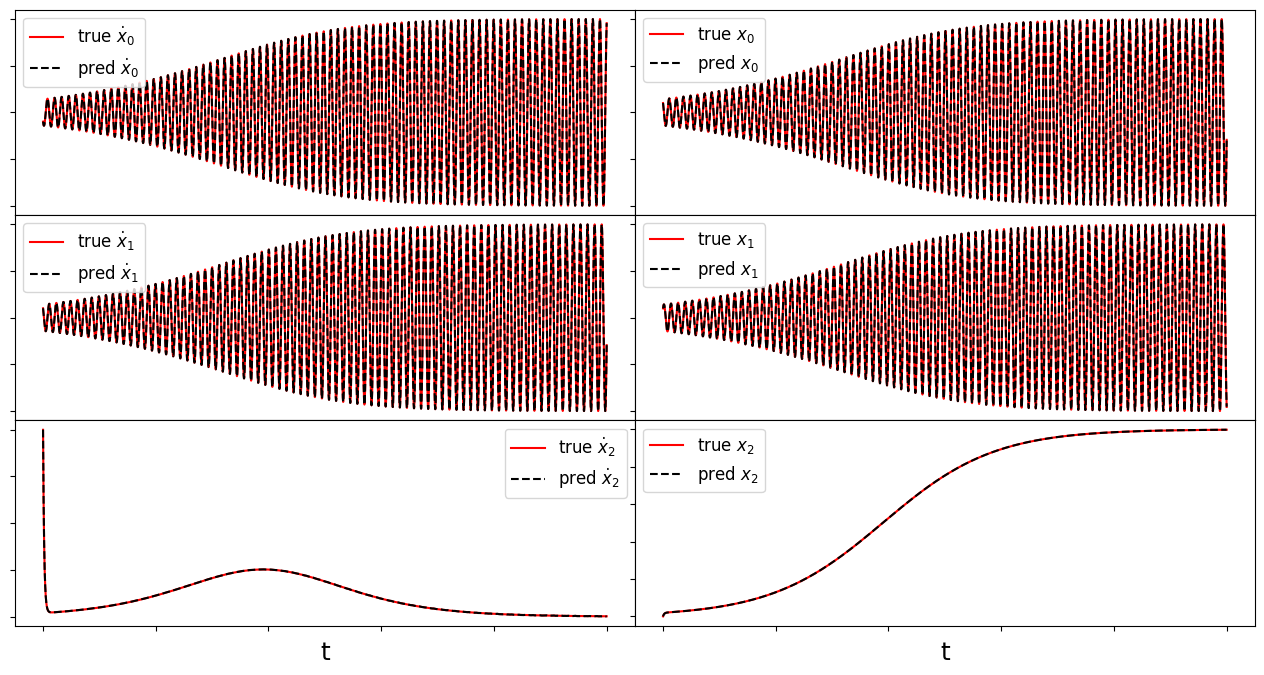

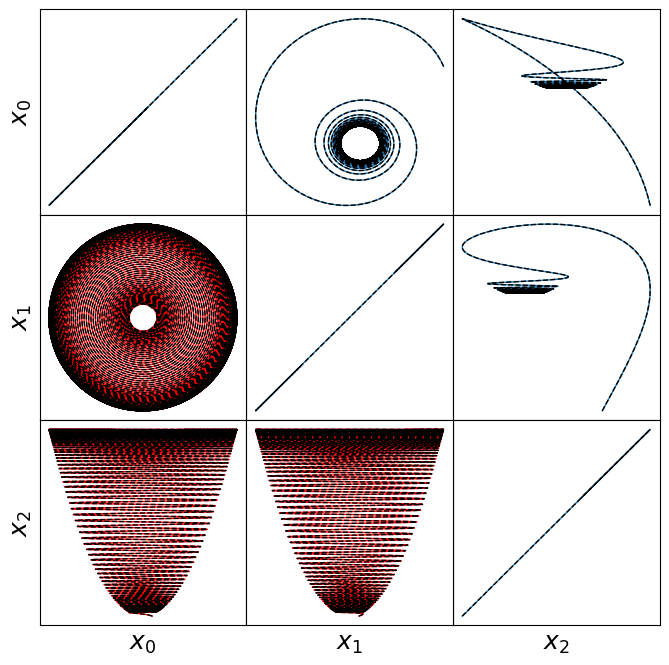

Frobenius Error =  0.00574183297755577
optimal m:  [-0.04338675 -0.02081754  1.31764483]
As eigvals:  [-1.30948229 -1.30762891 -0.99811593]
Maximum deviation from having zero totally symmetric part:  5.194733532221107e-13
Estimate of trapping region size, Rm =  1.32029234458837
Normalized trapping region size, Reff =  216.615691818847
Local stability size, R_ls=  1109320615734.78
Frobenius coefficient error =  1.309300483831643
Time-averaged derivative error =  8.811660624613155e-12


In [4]:

# define hyperparameters
max_iter = 5000
eta = 1.0e5
alpha = 1e20
beta = 1e-8
threshold = 0.0
alpha_m = 1e-1 * eta


# run trapping SINDy algorithm
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    )

model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'meanfield')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'meanfield')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius Error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_meanfield = np.zeros(Xi.shape)
Xi_meanfield[:r, :r] = np.asarray([[0.01, -1, 0], [1, 0.01, 0], [0, 0, -1]]).T
Xi_meanfield[r + 1, 0] = -1
Xi_meanfield[r + 2, 1] = -1
Xi_meanfield[r + 3, 2] = 1
Xi_meanfield[r + 4, 2] = 1
coef_pred = np.linalg.norm(Xi_meanfield - Xi) / np.linalg.norm(Xi_meanfield)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

This shows that local stability works pretty well on both modeling and sparse identification for systems with strict EPNs. Now let us examine this on a little more complex system with a deviation from $\bm Q$ having zero totally symmetric part.

# Atmospheric oscillator model
$$
\begin{align}

    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} = \begin{bmatrix}
    \mu_1 & 0 & 0 \\
    0 & \mu_2 & \omega \\
    0 & -\omega & \mu_2 
    \end{bmatrix}\begin{bmatrix} 
    x \\ 
    y \\
    z 
    \end{bmatrix}
    +
    \begin{bmatrix}
    \sigma xy \\
    \kappa yz + \beta z^2 - (\sigma + \epsilon) x^2 \\
    - \kappa y^2 - \beta yz
    \end{bmatrix}.
\end{align}
$$

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 4.959e-05 ... 2.622e-07 ... 0.00e+00 ... 2.26e-19 ... 6.39e-10 ... 4.98e-05


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:724: UserWarning: TrappingSR3._solve_nonsparse_relax_and_split using naive pinv() call here, be careful with rcond parameter.
  warnings.warn(


  500 ... 4.959e-05 ... 5.182e-09 ... 0.00e+00 ... 2.26e-19 ... 6.39e-10 ... 4.96e-05
 1000 ... 4.959e-05 ... 4.928e-09 ... 0.00e+00 ... 2.26e-19 ... 6.39e-10 ... 4.96e-05
 1500 ... 4.959e-05 ... 4.905e-09 ... 0.00e+00 ... 2.26e-19 ... 6.39e-10 ... 4.96e-05
 2000 ... 4.959e-05 ... 4.903e-09 ... 0.00e+00 ... 2.26e-19 ... 6.39e-10 ... 4.96e-05
(x0)' = 0.050 x0 + 1.100 x0x1
(x1)' = -0.001 x0 + -0.010 x1 + 3.000 x2 + 0.001 x0x2 + -2.000 x1x2 + -1.100 x0x0 + -4.999 x2x2
(x2)' = -3.000 x1 + -0.010 x2 + -0.001 x0x1 + 4.999 x1x2 + 2.000 x1x1
Max deviation from the constraints =  1.753054582025323e-07


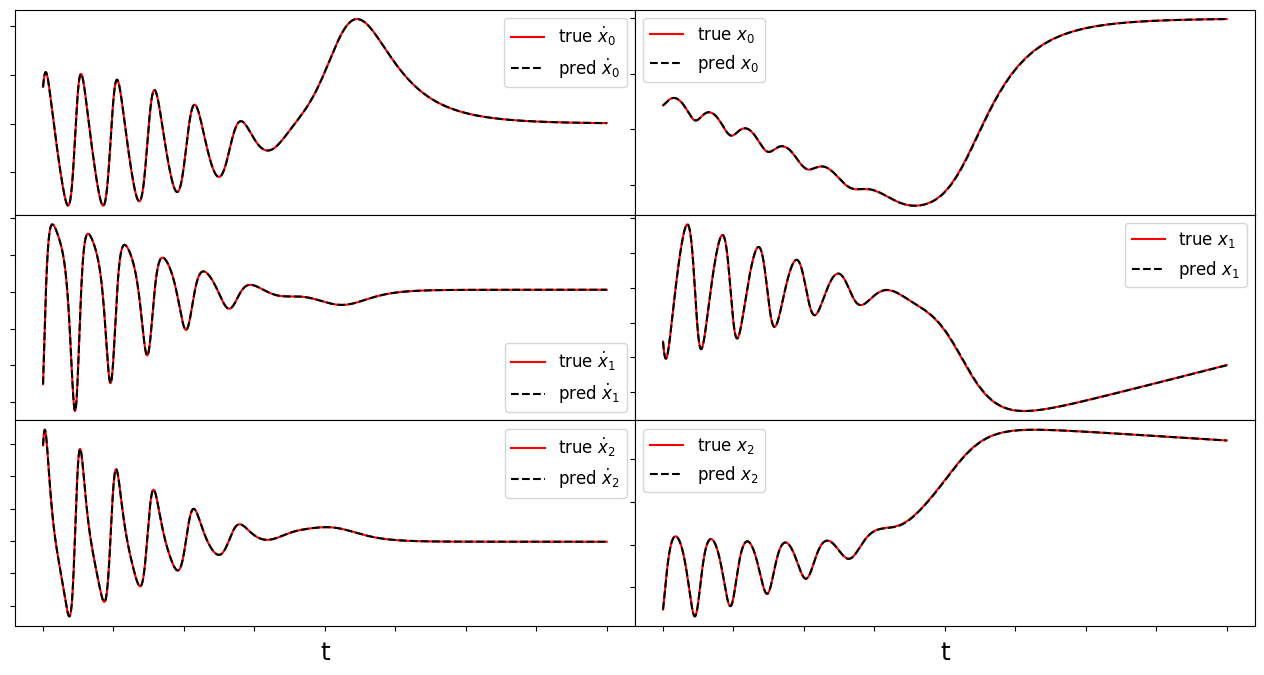

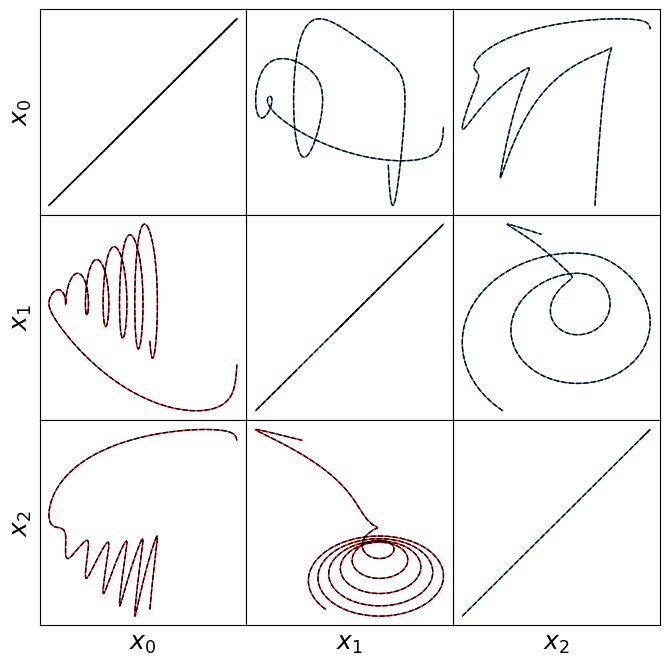

Frobenius error =  0.0022813260819903626
optimal m:  [-0.00462317 -1.02626544  0.41060029]
As eigvals:  [-5.96095202 -1.07882707 -0.00975827]
Maximum deviation from having zero totally symmetric part:  1.753054582025323e-07
Estimate of trapping region size, Rm =  343.367543810858
Normalized trapping region size, Reff =  608.716261893402
Local stability size, R_ls=  31794.4721124571
Frobenius coefficient error =  1.3940767053825058
Time-averaged derivative error =  1.727568986444496e-06


In [18]:
# define parameters
r = 3
sigma = 1.1
beta = -5.0
eps = 0.01
k1 = 5
k2 = 1
mu1 = eps * k1
mu2 = -eps * k2
alpha = -2.0
omega = 3.0

# Make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = np.random.rand(3) - 0.5
x_train = solve_ivp(oscillator, t_span, x0, t_eval=t, 
                    args=(mu1, mu2, omega, alpha, beta, sigma), 
                    **integrator_keywords).y.T
x0 = np.random.rand(3) - 0.5
x_test = solve_ivp(oscillator, t_span, x0, t_eval=t,
                   args=(mu1, mu2, omega, alpha, beta, sigma), 
                   **integrator_keywords).y.T

# define hyperparameters
max_iter = 5000
eta = 1.0e8
alpha = 1e20
beta = 1e-4
threshold = 0.0
alpha_m = 1e-1 * eta

# run trapping SINDy, reusing previous threshold, max_iter and constraints
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    # alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
    )
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
L = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
print('Max deviation from the constraints = ', Q_sum)

# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'oscillator')
make_lissajou(r, x_train, x_test, x_train_pred, x_test_pred, 'oscillator')
E_pred = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
print('Frobenius error = ', E_pred)
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)

# compute relative Frobenius error in the model coefficients
Xi_oscillator = np.zeros(Xi.shape)
Xi_oscillator[:r, :r] = np.asarray([[0.05, 0, 0], 
                                    [0, -0.01, 3.0], 
                                    [0, -3.0, -0.01]]).T
Xi_oscillator[r, 0] = 1.1
Xi_oscillator[r + 2, 1] = -2
Xi_oscillator[r + 3, 1] = -1.1 - 1e-3
Xi_oscillator[r + 5, 1] = -5
Xi_oscillator[r + 2, 2] = 5
Xi_oscillator[r + 4, 2] = 2
coef_pred = np.linalg.norm(Xi_oscillator - Xi) / np.linalg.norm(Xi_oscillator)
print('Frobenius coefficient error = ', coef_pred)

# Compute time-averaged dX/dt error
deriv_error = np.zeros(xdot_test.shape[0])
for i in range(xdot_test.shape[0]):
    deriv_error[i] = np.dot(xdot_test[i, :] - xdot_test_pred[i, :], 
                            xdot_test[i, :] - xdot_test_pred[i, :])  / np.dot(
                            xdot_test[i, :], xdot_test[i, :])
print('Time-averaged derivative error = ', np.nanmean(deriv_error))

# Lorenz

The algorithm works pretty well on nonchaotic systems in general, but what about chaotic systems?

$$
\begin{align}
    \frac{d}{dt}\begin{bmatrix}
    x \\ 
    y \\
    z \\
    \end{bmatrix} &= \begin{bmatrix}
    -\sigma & \sigma & 0 \\
    \rho & -1 & 0 \\
    0 & 0 & -\beta
    \end{bmatrix}
    \begin{bmatrix}
    x \\
    y \\
    z
    \end{bmatrix}
    +
    \begin{bmatrix}
    0 \\
    -xz \\
    xy
    \end{bmatrix}, \qquad
    \mathbf{A}^S = \begin{bmatrix}
    -\sigma & \frac{1}{2}(\rho+\sigma - m_3) & \frac{1}{2}m_2 \\
    \frac{1}{2}(\rho+\sigma - m_3) & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}.
\end{align}
$$

For Lorenz's choice of parameters, $\sigma = 10$, $\rho = 28$, $\beta  = 8/3$, this system is known to exhibit a stable attractor. For $\mathbf{m} = [0,m_2,\rho+\sigma]$ ($m_1$ does not contribute to $\mathbf{A}^S$ so we set it to zero),

$$
\begin{align}
    \mathbf{A}^S &= \begin{bmatrix}
    -\sigma & 0 & \frac{1}{2}m_2 \\
    0 & -1 & 0 \\
    \frac{1}{2}m_2 & 0 & -\beta 
    \end{bmatrix}, \qquad
    \lambda_1 = -1, \qquad \lambda_{\pm} = -\frac{1}{2}\left[\beta+\sigma \mp \sqrt{m_2^2 + (\beta-\sigma)^2}\right],
\end{align}
$$

so that if $\lambda_{\pm} < 0$, then $-2\sqrt{\sigma\beta} < m_2 < 2\sqrt{\sigma\beta}$. 
Our algorithm can successfully identify the optimal $\mathbf{m}$, and can be used to identify the inequality bounds on $m_2$ for stability.

In [7]:
# define parameters
r = 3
N = int((r ** 2 + 3 * r) / 2.0) + 1

# make training and testing data
dt = 0.01
T = 40
t = np.arange(0, T + dt, dt)
t_span = (t[0], t[-1])
x0 = [1, -1, 20]
x_train = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T
x0 = (np.random.rand(3) - 0.5) * 30
x_test = solve_ivp(lorenz, t_span, x0, t_eval=t, **integrator_keywords).y.T

max_iter = 20000
eta = 1.0e5
alpha = 1e20
beta = 1e-8
threshold = 0.0
alpha_m = 2e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    # alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 2.474e+02 ... 1.272e-03 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:724: UserWarning: TrappingSR3._solve_nonsparse_relax_and_split using naive pinv() call here, be careful with rcond parameter.
  warnings.warn(


 2000 ... 2.474e+02 ... 2.669e-05 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
 4000 ... 2.474e+02 ... 3.630e-06 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
 6000 ... 2.474e+02 ... 1.186e-06 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
 8000 ... 2.474e+02 ... 5.636e-07 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
10000 ... 2.474e+02 ... 3.259e-07 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
12000 ... 2.474e+02 ... 2.121e-07 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
14000 ... 2.474e+02 ... 1.493e-07 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
16000 ... 2.474e+02 ... 1.111e-07 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02
18000 ... 2.474e+02 ... 8.619e-08 ... 0.00e+00 ... 4.93e-21 ... 1.24e+00 ... 2.49e+02


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 20000 iters.
  warnings.warn(


(x0)' = 0.059 1 + -9.871 x0 + 9.939 x1 + -0.009 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = -0.246 1 + 27.758 x0 + -0.916 x1 + 0.029 x2 + -0.001 x0x1 + -0.993 x0x2 + -0.002 x1x2 + 0.001 x0x0 + -0.001 x2x2
(x2)' = 0.096 1 + 0.001 x0 + -0.010 x1 + -2.665 x2 + 0.993 x0x1 + 0.001 x1x2 + 0.003 x0x0 + 0.002 x1x1
optimal m:  [-1.14148236 -0.12584065 36.10795582]
As eigvals:  [-10.06307751  -2.66238588  -0.88251103]
Maximum deviation from having zero totally symmetric part:  9.264225553477979e-05
Estimate of trapping region size, Rm =  112.122399289834
Normalized trapping region size, Reff =  4.72101048743089
Local stability size, R_ls=  5387.72187066165


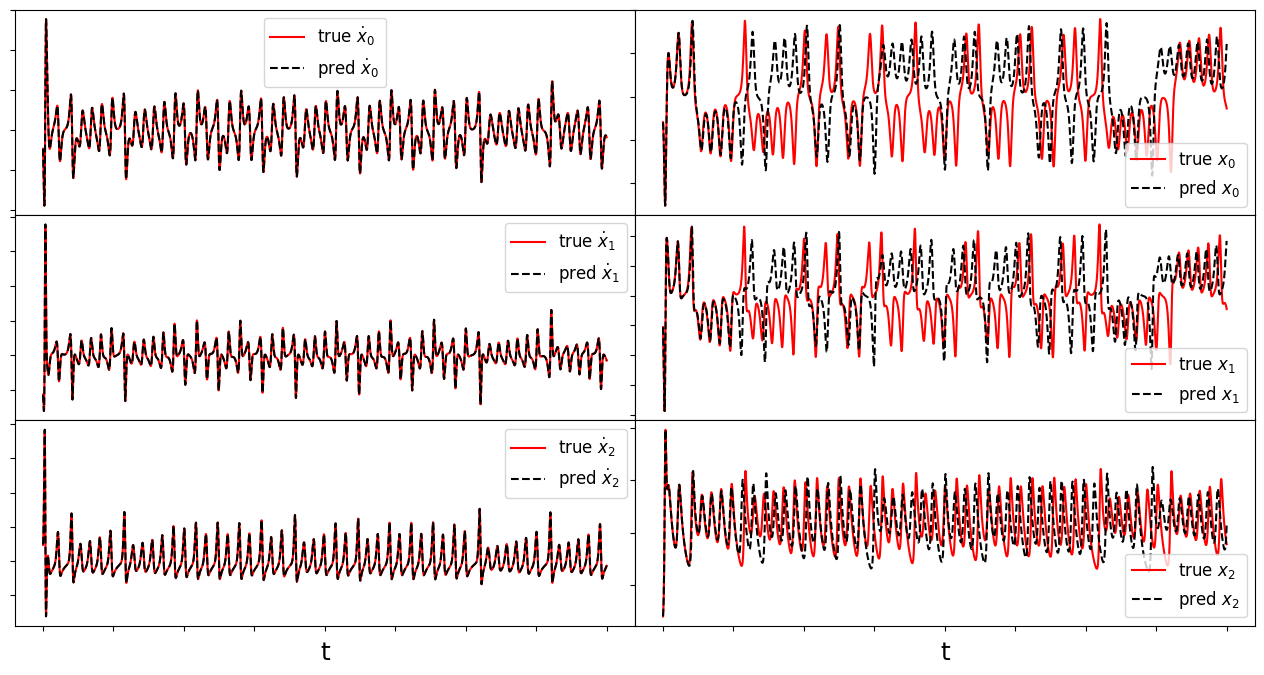

In [ ]:
# plotting and analysis
make_fits(r, t, xdot_test, xdot_test_pred, x_test, x_test_pred, 'lorenz')

Let us train again with $\ell_1$ regularizer.

In [13]:
max_iter = 2000
eta = 1.0e3
alpha = 1e20
beta = 1e-8
threshold = 1e4
alpha_m = 2e-1 * eta

# run trapping SINDy... no more constraints!
sindy_opt = ps.TrappingSR3(
    threshold=threshold, eta=eta,
    gamma=-1,
    alpha_m=alpha_m,
    alpha=alpha,
    beta=beta,
    max_iter=max_iter,
    verbose=True,
)
model = ps.SINDy(
    optimizer=sindy_opt,
    feature_library=sindy_library,
)
model.fit(x_train, t=t)
model.print()
Xi = model.coefficients().T
PL_tensor = sindy_opt.PL_
PQ_tensor = sindy_opt.PQ_
Lenergy = np.tensordot(PL_tensor, Xi, axes=([3, 2], [0, 1]))
Qenergy = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
mean_val = np.mean(x_test_pred, axis=0)
mean_val = np.sqrt(np.sum(mean_val ** 2))
check_local_stability(r, Xi, sindy_opt, mean_val)
Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))

 Iter ... |y-Xw|^2 ... |Pw-A|^2/eta ... |w|_1 ... |Qijk|/a ... |Qijk+...|/b ...   Total:
    0 ... 1.521e+04 ... 1.282e-03 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
  200 ... 1.521e+04 ... 3.601e-06 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
  400 ... 1.521e+04 ... 4.777e-07 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
  600 ... 1.521e+04 ... 1.394e-07 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
  800 ... 1.521e+04 ... 5.447e-08 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
 1000 ... 1.521e+04 ... 2.464e-08 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
 1200 ... 1.521e+04 ... 1.215e-08 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
 1400 ... 1.521e+04 ... 6.324e-09 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
 1600 ... 1.521e+04 ... 3.416e-09 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
 1800 ... 1.521e+04 ... 1.894e-09 ... 4.50e+05 ... 4.12e-21 ... 7.77e+02 ... 4.66e+05
(x0)' = -6.435 x0 + 7.833 x1 + -0.095 x0x2 + 0.055 

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


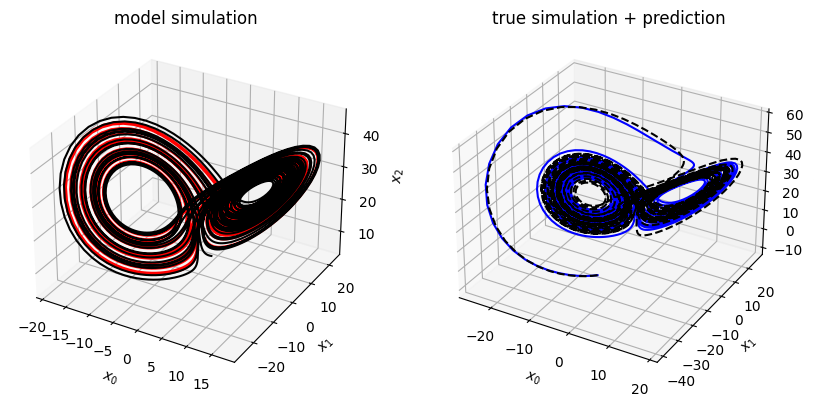

In [15]:
xdot_test = model.differentiate(x_test, t=t)
xdot_test_pred = model.predict(x_test)
x_train_pred = model.simulate(x_train[0, :], t, integrator_kws=integrator_keywords)
x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot(x_train[:, 0], x_train[:, 1], x_train[:, 2], 'r-')
ax1.plot(x_train_pred[:, 0], x_train_pred[:, 1], x_train_pred[:, 2], 'k-')
ax1.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='model simulation')

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(x_test[:, 0], x_test[:, 1], x_test[:, 2], 'b')
ax2.plot(x_test_pred[:, 0], x_test_pred[:, 1], x_test_pred[:, 2], 'k--')
ax2.set(xlabel='$x_0$', ylabel='$x_1$',
        zlabel='$x_2$', title='true simulation + prediction')
fig.show()

Now let's do a sweep.

In [23]:
thresholds = np.array([0, 10, 100, 1e3, 1e4, 1e5])
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:724: UserWarning: TrappingSR3._solve_nonsparse_relax_and_split using naive pinv() call here, be careful with rcond parameter.
  warnings.warn(
F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 20000 iters.
  warnings.warn(


(x0)' = 0.059 1 + -9.871 x0 + 9.939 x1 + -0.009 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = -0.246 1 + 27.758 x0 + -0.916 x1 + 0.029 x2 + -0.001 x0x1 + -0.993 x0x2 + -0.002 x1x2 + 0.001 x0x0 + -0.001 x2x2
(x2)' = 0.096 1 + 0.001 x0 + -0.010 x1 + -2.665 x2 + 0.993 x0x1 + 0.001 x1x2 + 0.003 x0x0 + 0.002 x1x1
optimal m:  [-1.10357645 -0.11845937 37.89663554]
As eigvals:  [-9.97301858 -2.66229235 -0.98045848]
Maximum deviation from having zero totally symmetric part:  9.264119492865457e-05
Estimate of trapping region size, Rm =  105.649856918118
Normalized trapping region size, Reff =  4.37214283468456
Local stability size, R_ls=  6004.67683247892


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.869 x0 + 9.937 x1 + -0.004 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = -0.177 1 + 27.751 x0 + -0.911 x1 + 0.023 x2 + -0.001 x0x1 + -0.993 x0x2 + -0.002 x1x2 + 0.001 x0x0 + -0.001 x2x2
(x2)' = 0.079 1 + -0.002 x0 + -0.006 x1 + -2.665 x2 + 0.992 x0x1 + 0.001 x1x2 + 0.003 x0x0 + 0.002 x1x1
optimal m:  [-1.1396403  -0.12366837 36.75213562]
As eigvals:  [-10.01145707  -2.66190274  -0.93818239]
Maximum deviation from having zero totally symmetric part:  8.476291009103198e-05
Estimate of trapping region size, Rm =  106.992434146837
Normalized trapping region size, Reff =  4.56744688482523
Local stability size, R_ls=  6283.30087076666


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.839 x0 + 9.919 x1 + -0.003 x2 + -0.004 x0x2 + 0.001 x1x2
(x1)' = 27.694 x0 + -0.872 x1 + 0.008 x2 + -0.991 x0x2 + -0.003 x1x2
(x2)' = -0.001 x1 + -2.662 x2 + 0.990 x0x1 + 0.004 x0x0 + 0.003 x1x1
optimal m:  [-1.14751035 -0.12515932 36.74480157]
As eigvals:  [-10.01178197  -2.66015155  -0.94037707]
Maximum deviation from having zero totally symmetric part:  4.314309989673698e-05
Estimate of trapping region size, Rm =  105.833880929524
Normalized trapping region size, Reff =  4.43536062243993
Local stability size, R_ls=  12478.4948996896


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.411 x0 + 9.662 x1 + -0.002 x2 + -0.015 x0x2 + 0.008 x1x2
(x1)' = 27.179 x0 + -0.536 x1 + 0.010 x2 + -0.977 x0x2 + -0.013 x1x2
(x2)' = 0.002 x0 + -2.668 x2 + 0.969 x0x1 + 0.015 x0x0 + 0.013 x1x1
optimal m:  [-1.15252911 -0.14413267 36.71997069]
As eigvals:  [-10.00975326  -2.67325793  -0.95242728]
Maximum deviation from having zero totally symmetric part:  0.00023507226368826682
Estimate of trapping region size, Rm =  108.967302290043
Normalized trapping region size, Reff =  4.60522709459492
Local stability size, R_ls=  2230.24591822877


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -6.435 x0 + 7.833 x1 + -0.095 x0x2 + 0.055 x1x2 + -0.001 x2x2
(x1)' = 25.312 x0 + 0.607 x1 + 0.015 x2 + -0.924 x0x2 + -0.046 x1x2
(x2)' = -2.711 x2 + 0.870 x0x1 + 0.001 x0x2 + 0.094 x0x0 + 0.046 x1x1 + -0.001 x2x2
optimal m:  [-1.14246627 -0.2100248  36.3718151 ]
As eigvals:  [-9.9439275  -2.79813475 -0.98537454]
Maximum deviation from having zero totally symmetric part:  0.0036968815830309854
Estimate of trapping region size, Rm =  0
Normalized trapping region size, Reff =  0.0
Local stability size, R_ls=  0
(x0)' = 3.698 x1 + -0.266 x0x2 + 0.160 x1x2 + -0.003 x2x2
(x1)' = 15.355 x0 + 6.345 x1 + -0.652 x0x2 + -0.202 x1x2 + 0.004 x2x2
(x2)' = -2.664 x2 + 0.498 x0x1 + 0.004 x0x2 + -0.002 x1x2 + 0.267 x0x0 + 0.206 x1x1 + -0.003 x2x2
optimal m:  [-1.0166117  -0.55274706 36.52807765]
As eigvals:  [-9.77616481 -2.90141876 -0.99961271]
Maximum deviation from having zero totally symmetric part:  0.010123856932117169
Estimate of trapping region size, Rm =  0
Normalized trapping region 

Now draw these results!

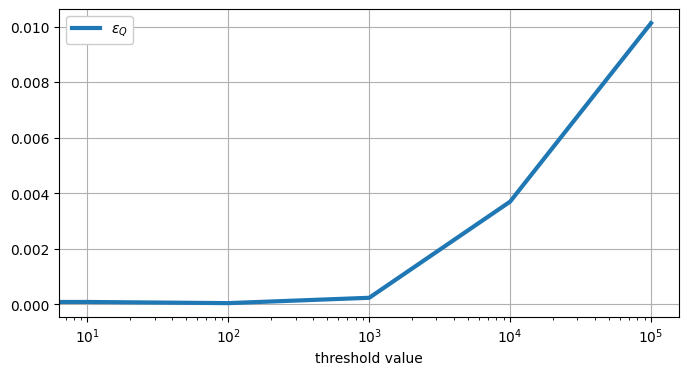

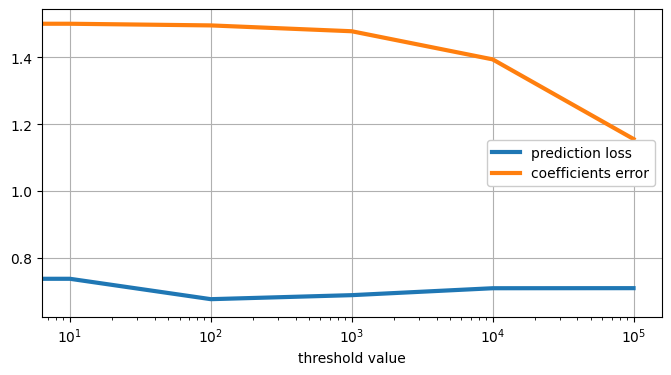

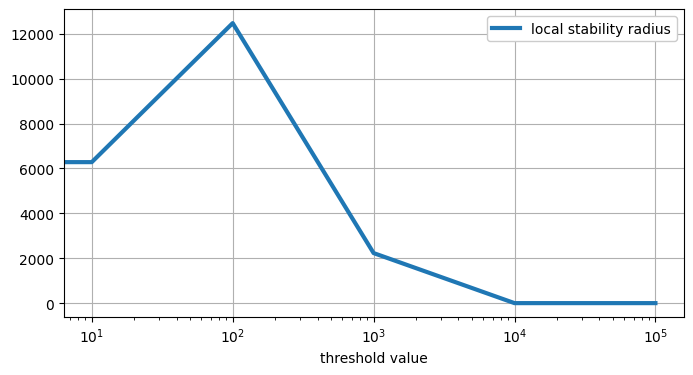

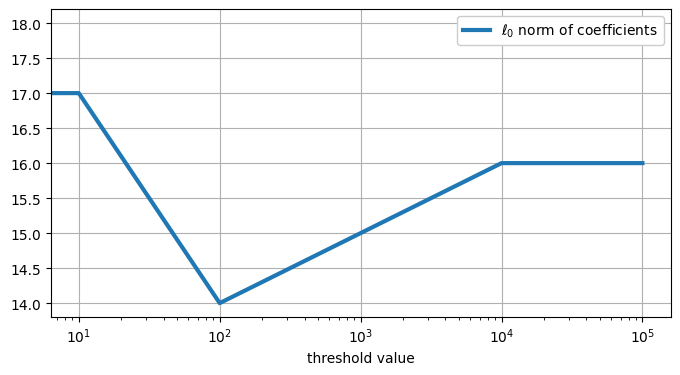

In [24]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

In [28]:
thresholds = np.arange(10, 460, 50)
deviation = np.zeros(np.size(thresholds))
pred_loss = np.zeros(np.size(thresholds))
coef_error = np.zeros(np.size(thresholds))
r_ls = np.zeros(np.size(thresholds))
l0 = np.zeros(np.size(thresholds))

sigma = 10
rho = 28
beta = 8.0 / 3.0
Xi_lorenz = np.zeros(Xi.shape)
Xi_lorenz[:r, :r] = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]]).T
Xi_lorenz[r + 1, 1] = -1
Xi_lorenz[r, 2] = 1

for i in range(len(thresholds)):

    max_iter = 2000
    eta = 1.0e5
    alpha = 1e20
    beta = 1e-8
    threshold = 0.1
    alpha_m = 2e-1 * eta

    if thresholds[i] == 0:
        max_iter = 20000

    # run trapping SINDy... no more constraints!
    sindy_opt = ps.TrappingSR3(
        threshold=thresholds[i], eta=eta,
        gamma=-1,
        alpha_m=alpha_m,
        alpha=alpha,
        beta=beta,
        max_iter=max_iter,
        verbose=False,
    )
    model = ps.SINDy(
        optimizer=sindy_opt,
        feature_library=sindy_library,
    )
    model.fit(x_train, t=t)
    model.print()
    Xi = model.coefficients().T
    x_test_pred = model.simulate(x_test[0, :], t, integrator_kws=integrator_keywords)

    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mean_val = np.mean(x_test_pred, axis=0)
    mean_val = np.sqrt(np.sum(mean_val ** 2))
    rm, r_ls[i] = check_local_stability(r, Xi, sindy_opt, mean_val)
    Q = np.tensordot(sindy_opt.PQ_, Xi, axes=([4, 3], [0, 1]))
    Q_sum = np.max(np.abs((Q + np.transpose(Q, [1, 2, 0]) + np.transpose(Q, [2, 0, 1]))))
    deviation[i] = np.max(np.abs(Q_sum))
    coef_error[i] = np.linalg.norm(Xi_lorenz - Xi) / np.linalg.norm(Xi_lorenz)
    pred_loss[i] = np.linalg.norm(x_test - x_test_pred) / np.linalg.norm(x_test)
    nonzero_ind = np.abs(Xi) >= 1e-3
    nonzeros = np.zeros(np.shape(Xi))
    nonzeros[nonzero_ind] = 1
    l0[i] = np.count_nonzero(nonzeros)

F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.869 x0 + 9.937 x1 + -0.004 x2 + -0.001 x0x1 + -0.003 x0x2 + 0.001 x1x2 + 0.001 x1x1
(x1)' = -0.177 1 + 27.751 x0 + -0.911 x1 + 0.023 x2 + -0.001 x0x1 + -0.993 x0x2 + -0.002 x1x2 + 0.001 x0x0 + -0.001 x2x2
(x2)' = 0.079 1 + -0.002 x0 + -0.006 x1 + -2.665 x2 + 0.992 x0x1 + 0.001 x1x2 + 0.003 x0x0 + 0.002 x1x1
optimal m:  [-1.1396403  -0.12366837 36.75213562]
As eigvals:  [-10.01145707  -2.66190274  -0.93818239]
Maximum deviation from having zero totally symmetric part:  8.476312581719549e-05
Estimate of trapping region size, Rm =  106.992438824509
Normalized trapping region size, Reff =  4.50219154097994
Local stability size, R_ls=  6283.28460381310


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.858 x0 + 9.930 x1 + -0.003 x2 + -0.003 x0x2 + 0.001 x1x2
(x1)' = 27.717 x0 + -0.887 x1 + 0.008 x2 + -0.992 x0x2 + -0.003 x1x2
(x2)' = -0.001 x1 + -2.661 x2 + 0.991 x0x1 + 0.003 x0x0 + 0.003 x1x1
optimal m:  [-1.14585417 -0.12351981 36.74589909]
As eigvals:  [-10.01175595  -2.65955773  -0.93976971]
Maximum deviation from having zero totally symmetric part:  4.7188141543583226e-05
Estimate of trapping region size, Rm =  105.973219429315
Normalized trapping region size, Reff =  4.47594011509087
Local stability size, R_ls=  11392.1760724171


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.834 x0 + 9.916 x1 + -0.003 x2 + -0.004 x0x2 + 0.001 x1x2
(x1)' = 27.688 x0 + -0.868 x1 + 0.007 x2 + -0.991 x0x2 + -0.003 x1x2
(x2)' = -2.662 x2 + 0.990 x0x1 + 0.004 x0x0 + 0.003 x1x1
optimal m:  [-1.14800184 -0.12561945 36.74451527]
As eigvals:  [-10.01179482  -2.66029762  -0.94052834]
Maximum deviation from having zero totally symmetric part:  4.304638090427441e-05
Estimate of trapping region size, Rm =  105.818236241709
Normalized trapping region size, Reff =  4.44142030832387
Local stability size, R_ls=  12508.8145461863


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.810 x0 + 9.901 x1 + -0.003 x2 + -0.004 x0x2 + 0.002 x1x2
(x1)' = 27.660 x0 + -0.850 x1 + 0.007 x2 + -0.990 x0x2 + -0.004 x1x2
(x2)' = -2.662 x2 + 0.989 x0x1 + 0.004 x0x0 + 0.004 x1x1
optimal m:  [-1.14981096 -0.12733851 36.7431628 ]
As eigvals:  [-10.01180075  -2.66102707  -0.94126663]
Maximum deviation from having zero totally symmetric part:  4.256165860337235e-05
Estimate of trapping region size, Rm =  105.741697373341
Normalized trapping region size, Reff =  4.49537139249302
Local stability size, R_ls=  12662.5704655462


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.787 x0 + 9.887 x1 + -0.002 x2 + -0.005 x0x2 + 0.002 x1x2
(x1)' = 27.631 x0 + -0.831 x1 + 0.007 x2 + -0.989 x0x2 + -0.004 x1x2
(x2)' = -2.662 x2 + 0.988 x0x1 + 0.005 x0x0 + 0.004 x1x1
optimal m:  [-1.15069684 -0.12834029 36.7419345 ]
As eigvals:  [-10.0117234   -2.66175369  -0.94197774]
Maximum deviation from having zero totally symmetric part:  4.363045389769657e-05
Estimate of trapping region size, Rm =  105.700078609285
Normalized trapping region size, Reff =  4.48818262172193
Local stability size, R_ls=  12359.2425234964


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.763 x0 + 9.873 x1 + -0.002 x2 + -0.006 x0x2 + 0.002 x1x2
(x1)' = 27.603 x0 + -0.812 x1 + 0.007 x2 + -0.989 x0x2 + -0.005 x1x2
(x2)' = -2.663 x2 + 0.987 x0x1 + 0.006 x0x0 + 0.005 x1x1
optimal m:  [-1.15163263 -0.12931125 36.74064612]
As eigvals:  [-10.01165222  -2.66248152  -0.94268686]
Maximum deviation from having zero totally symmetric part:  4.495013137660424e-05
Estimate of trapping region size, Rm =  105.663947183021
Normalized trapping region size, Reff =  4.43099084710367
Local stability size, R_ls=  12002.4321817881


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.739 x0 + 9.859 x1 + -0.002 x2 + -0.006 x0x2 + 0.003 x1x2
(x1)' = 27.574 x0 + -0.794 x1 + 0.008 x2 + -0.988 x0x2 + -0.005 x1x2
(x2)' = -2.663 x2 + 0.985 x0x1 + 0.006 x0x0 + 0.005 x1x1
optimal m:  [-1.15256664 -0.13029256 36.73931808]
As eigvals:  [-10.01158289  -2.66320912  -0.94339202]
Maximum deviation from having zero totally symmetric part:  4.626912351414058e-05
Estimate of trapping region size, Rm =  105.628144880791
Normalized trapping region size, Reff =  4.44075955870683
Local stability size, R_ls=  11666.1020449083


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.716 x0 + 9.845 x1 + -0.002 x2 + -0.007 x0x2 + 0.003 x1x2
(x1)' = 27.545 x0 + -0.775 x1 + 0.008 x2 + -0.987 x0x2 + -0.006 x1x2
(x2)' = -2.663 x2 + 0.984 x0x1 + 0.007 x0x0 + 0.006 x1x1
optimal m:  [-1.15338299 -0.13125162 36.73797707]
As eigvals:  [-10.01150469  -2.66393544  -0.94408979]
Maximum deviation from having zero totally symmetric part:  4.7584718667084e-05
Estimate of trapping region size, Rm =  105.592825319808
Normalized trapping region size, Reff =  4.49201402472807
Local stability size, R_ls=  11349.1453089426


F:\CodeWork\pysindy\pysindy\optimizers\trapping_sr3.py:891: ConvergenceWarning: TrappingSR3._reduce did not converge after 2000 iters.
  warnings.warn(


(x0)' = -9.692 x0 + 9.830 x1 + -0.002 x2 + -0.008 x0x2 + 0.003 x1x2
(x1)' = 27.517 x0 + -0.757 x1 + 0.008 x2 + -0.986 x0x2 + -0.006 x1x2
(x2)' = -2.664 x2 + 0.983 x0x1 + 0.008 x0x0 + 0.006 x1x1
optimal m:  [-1.1538781  -0.13221896 36.73668003]
As eigvals:  [-10.01140018  -2.66465509  -0.94477346]
Maximum deviation from having zero totally symmetric part:  5.79882458447773e-05
Estimate of trapping region size, Rm =  105.748357582312
Normalized trapping region size, Reff =  4.45569583586339
Local stability size, R_ls=  9300.73055490310


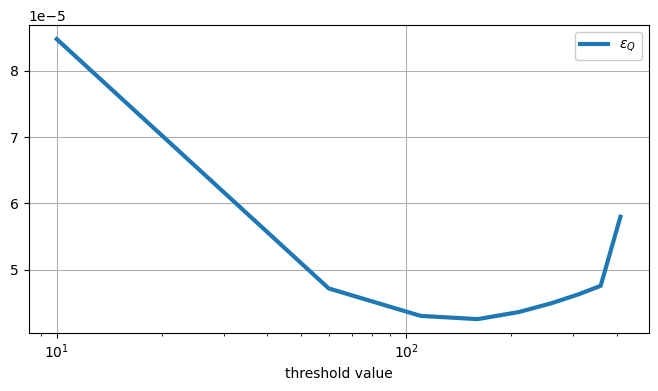

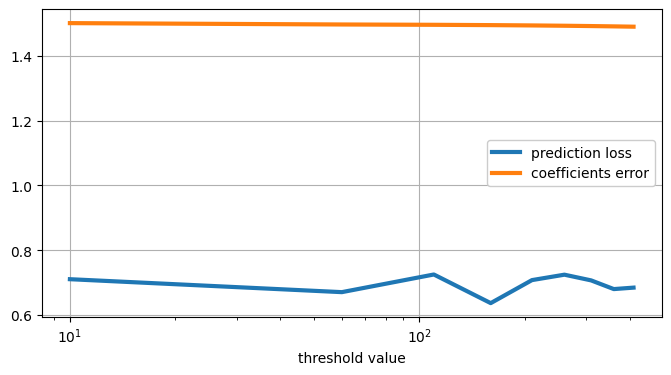

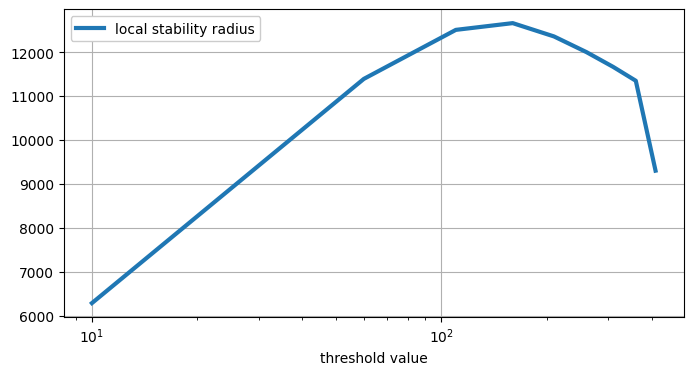

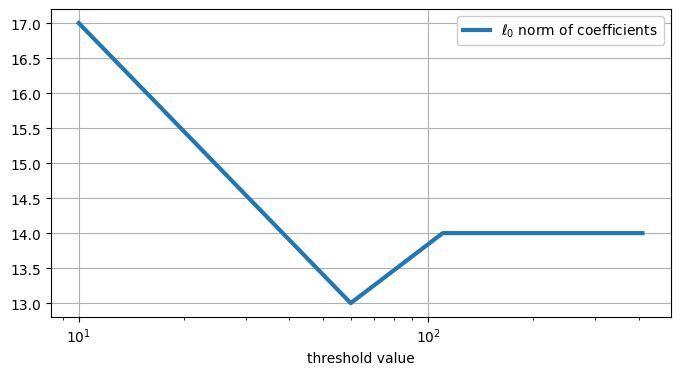

In [29]:
nonzero_ind = np.abs(Xi) >= 1e-3
nonzeros = np.zeros(np.shape(Xi))
nonzeros[nonzero_ind] = 1
l0[5] = np.count_nonzero(nonzeros)

fig1 = plt.figure(figsize=(8,4))
plt.plot(thresholds, deviation, label=r"$\epsilon_Q$", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig2 = plt.figure(figsize=(8,4))
plt.plot(thresholds, pred_loss, label=r"prediction loss", linewidth=3)
plt.plot(thresholds, coef_error, label=r"coefficients error", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig3 = plt.figure(figsize=(8,4))
plt.plot(thresholds, r_ls, label=r"local stability radius", linewidth=3)
plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

fig4 = plt.figure(figsize=(8,4))
plt.plot(thresholds, l0, label=r"$\ell_0$ norm of coefficients", linewidth=3)

plt.grid(True)
plt.xlabel("threshold value")
plt.legend(framealpha=1.0)
plt.xscale("log")

# We also want to introduce the ZSINDy method to build in sparsity to the trapping models.

ZSindy is a recent strategy to directly construct sparse dynamical models without applying the traditional sparse regularization. Based on Bayesian inference, ZSindy leverages sparse priors and the fact that for most physical systems, only a few relative terms determine the dynamics so to combine SINDy with Bayesian approach to achieve the parsimonious representation of dynamical systems.

A very